##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Optimizing the Text Generation Model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c04_nlp_optimizing_the_text_generation_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c04_nlp_optimizing_the_text_generation_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

You've already done some amazing work with generating new songs, but so far we've seen some issues with repetition and a fair amount of incoherence. By using more data and further tweaking the model, you'll be able to get improved results. We'll once again use the [Kaggle Song Lyrics Dataset](https://www.kaggle.com/mousehead/songlyrics) here.

## Import TensorFlow and related functions

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

## Get the Dataset

As noted above, we'll utilize the [Song Lyrics dataset](https://www.kaggle.com/mousehead/songlyrics) on Kaggle again.

In [3]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2023-03-19 08:02:00--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 142.250.1.139, 142.250.1.100, 142.250.1.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.1.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/90a20ol1k3ehglv7vq7u4145g24c412n/1679212875000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=9ad550a6-64a8-4b81-b7fb-218db32e84ed [following]
--2023-03-19 08:02:02--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/90a20ol1k3ehglv7vq7u4145g24c412n/1679212875000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=9ad550a6-64a8-4b81-b7fb-218db32e84ed
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 74.125.132.132, 2607:f8b0:4001:c00::84
Connecting to doc-04-ak-

## 250 Songs

Now we've seen a model trained on just a small sample of songs, and how this often leads to repetition as you get further along in trying to generate new text. Let's switch to using the 250 songs instead, and see if our output improves. This will actually be nearly 10K lines of lyrics, which should be sufficient.

Note that we won't use the full dataset here as it will take up quite a bit of RAM and processing time, but you're welcome to try doing so on your own later. If interested, you'll likely want to use only some of the more common words for the Tokenizer, which will help shrink processing time and memory needed (or else you'd have an output array hundreds of thousands of words long).

### Preprocessing

In [4]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [5]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


<ipython-input-4-fbdddccf8583>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


### Create Sequences and Labels

In [6]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

### Train a (Better) Text Generation Model

With more data, we'll cut off after 100 epochs to avoid keeping you here all day. You'll also want to change your runtime type to GPU if you haven't already (you'll need to re-run the above cells if you change runtimes).

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 33s 13ms/step - loss: 5.7536 - accuracy: 0.0612
Epoch 2/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.9706 - accuracy: 0.1281
Epoch 3/100
1480/1480 [==============================] - 11s 7ms/step - loss: 4.3580 - accuracy: 0.1864
Epoch 4/100
1480/1480 [==============================] - 12s 8ms/step - loss: 3.8394 - accuracy: 0.2448
Epoch 5/100
1480/1480 [==============================] - 11s 8ms/step - loss: 3.3881 - accuracy: 0.3032
Epoch 6/100
1480/1480 [==============================] - 11s 8ms/step - loss: 2.9987 - accuracy: 0.3597
Epoch 7/100
1480/1480 [==============================] - 11s 8ms/step - loss: 2.6706 - accuracy: 0.4078
Epoch 8/100
1480/1480 [==============================] - 11s 8ms/step - loss: 2.4024 - accuracy: 0.4502
Epoch 9/100
1480/1480 [==============================] - 13s 9ms/step - loss: 2.1725 - accuracy: 0.4871
Epoch 10/100
1480/1480 [==============================] - 13s 9

### View the Training Graph

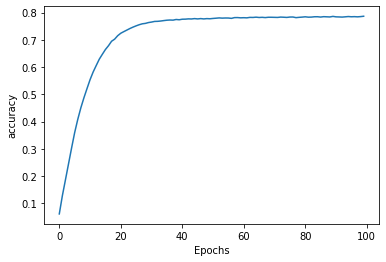

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate better lyrics!

This time around, we should be able to get a more interesting output with less repetition.

In [9]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 22ms/step
im feeling chills me to the cross the of the cow the while get out if you and the was the bridge the court you war the crowded flu the ni the the the the the the the the the the the the the the the the the the the that the the the the the the the the the the the the the the the the the the that the the the the the the the the the the the the the the the the the the that the the the the the the the the the the the the the the


### Varying the Possible Outputs

In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output? 

Switching from `model.predict_classes` to `model.predict_proba` will get us all of the class probabilities. We can combine this with `np.random.choice` to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [10]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

1/1 [==============================] - 0s 21ms/step
7


In [13]:
# Use this process for the full output generation
seed_text = "we wish you a "
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 19ms/step
we wish you a  merry christmas clear at a distance horse my heart would have a little and doubts the court the that love the se hacer the hacer hacer the court the the the the the the the that the that the the the the the the the the the the the the the the the the that the the the the the the the the the the the the the the the the the the that super the the the the the the the the the the the the the the the the the that the the the the the the the
